In [1]:
##########################################
# NACA 0012 DNS post-processing.         #
# Zhenyang Yuan                          #
# 25/5/2021                              #
##########################################
import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import scipy.signal
from numpy import linalg as LA
#from matplotlib.mlab import griddata
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#%matplotlib notebook
%matplotlib inline


from sys import argv

import pandas as pd

In [2]:
# load data set
def data_load_DNS(time,t,start,end,x_,y_,headline,varibles,numNodes,Lines):
    r = 4
    #x_ = np.asarray([])
    #y_ = np.asarray([])
    p_ = np.asarray([])

    x = np.asarray([])
    y = np.asarray([])
    p = np.asarray([])
    
    
        
    

    k = 0
    #for i in open("../send/"+str(time)+".dat").readlines():
    for i in open("/Users/yuanzhenyang/software/yuan_compute/aerofoil/postprocessing/datFiles/"+str(time)+".dat").readlines():
        if k > headline - 1:                                #get away with headers
            datContent = i.strip().split()                  #magic

            datContent = np.asarray(datContent)             #convert list to array
            datContent = datContent.astype(np.float64)      #convert str element to float

            if t == 0:
                if k < Lines*1 + headline :
                        x_ = np.concatenate((x_,datContent),axis=None)
                elif k < Lines*2 + headline :
                        y_ = np.concatenate((y_,datContent),axis=None)
                elif k < Lines*9 + headline and k > Lines*8 + headline - 1:
                        p_ = np.concatenate((p_,datContent),axis=None)
            else:
                if k < Lines*9 + headline and k > Lines*8 + headline - 1:
                        p_ = np.concatenate((p_,datContent),axis=None)


        k+=1
        if k > Lines*9 + headline:
            break

    for i in range(len(x_)):
        if abs(x_[i]) < r and abs(y_[i]) < r:
            if t == 0:
                x = np.concatenate((x,x_[i]),axis=None)
                y = np.concatenate((y,y_[i]),axis=None)
                p = np.concatenate((p,p_[i]),axis=None)
            else:
                p = np.concatenate((p,p_[i]),axis=None)

    print('Completed: '+str(time-start+1)+'/'+str(end-start+1)+'\n')

    if t == 0:
        return x,y,p,x_,y_
    elif time == end:
        print('Completed collecting data from Nektar++ DNS solution!')
        return p
    else:
        return p


In [3]:
start = 27    #27
end = 107      #47
time = np.arange(start,end+1,4)

headline=3
varibles=3   # x-1, y-2, rho-3, rhou-4, rhov-5, E-6, u-7, v-8, p-9, T, s, a, Mach, Sensor
numNodes=561450
#Lines=int(numNodes/5) #from tecplot
Lines=int(numNodes/1000)+1 #fieldconvert


x_ = np.asarray([])   #pruely for loading speed reason
y_ = np.asarray([])

x,y,p1,x_,y_ = data_load_DNS(time[0],0,start,end,x_,y_,headline,varibles,numNodes,Lines)

p = np.zeros([len(time), len(p1)])
p[0] = p1
for i in range(len(time)):
    if i > 0:
        p[i][:]=data_load_DNS(time[i],1,start,end,x_,y_,headline,varibles,numNodes,Lines)


Completed: 1/81

Completed: 5/81

Completed: 9/81

Completed: 13/81

Completed: 17/81

Completed: 21/81

Completed: 25/81

Completed: 29/81

Completed: 33/81

Completed: 37/81

Completed: 41/81

Completed: 45/81

Completed: 49/81

Completed: 53/81

Completed: 57/81

Completed: 61/81

Completed: 65/81

Completed: 69/81

Completed: 73/81

Completed: 77/81

Completed: 81/81

Completed collecting data from Nektar++ DNS solution!


In [4]:
## calculate total, mean, fluctuation pressure values
def fluc_pressure(p,time):
    dp = np.zeros([len(time), len(p[0])])
    dptuda = np.zeros([len(time), len(p[0])])
    dpmean = np.zeros(len(p[0]))
    for i in range(len(time)):
        dp[i] = p[i] - 1/1.4*np.ones(len(p[0]))
        dpmean += dp[i]
    dpmean = dpmean/len(time)
    for i in range(len(time)):
        dptuda[i] = dp[i] - dpmean

    return dp,dpmean,dptuda


## calculate rms values of input time depended arrays
## root mean square
def rms(p,time):
    pms_ = np.zeros(p.shape[1])
    
    for i in range(len(time)):
        pms_ += p[i]**2
            
    pms = pms_/len(time)
    prms = np.sqrt(pms)
    
    return pms, prms


def polar_coor(x,y):
    theta =np.arctan2(y,x)
    r = np.sqrt(x**2+y**2)
    return theta,r

## Trailing Edge Directivity

In [5]:
dp,dpmean,dptuda = fluc_pressure(p,time)

In [6]:
dptuda_ms,dptuda_rms = rms(dptuda,time)

In [24]:
## trailing edge point

def rotate(x,y):
    deg = -pi/60    # degree in rad
    x = x*np.cos(deg) - y*np.sin(deg)
    y = x*np.sin(deg) + y*np.cos(deg)
    return x,y

#xt = 0.0
xt = 0.9806050635537246
yt = 0

xt,yt = rotate(xt,yt)
print(xt,yt)

0.9792611783946352 -0.05125057018287524


In [25]:
## set the new centre point of the cordinate to this point
xn = x - xt
yn = y - yt

In [26]:
theta,r = polar_coor(xn,yn)

In [27]:
rr = r #/ (1 - 0.2*np.cos(theta))
#rr = r * np.sqrt(1-0.2**2*np.cos(theta))

In [28]:
theta_plot1 = np.asarray([])
r_plot1 = np.asarray([])
dptuda_rms_plot = np.asarray([])
tol = 0.015
for i in range(len(r)):
    if abs(rr[i] - 3) <= tol:
        theta_plot1 = np.concatenate((theta_plot1,theta[i]),axis=None)
        r_plot1 = np.concatenate((r_plot1,r[i]),axis=None)
        dptuda_rms_plot = np.concatenate((dptuda_rms_plot,dptuda_rms[i]),axis=None)

Text(0.5, 1.0, 'Measured at trailing edge point, r = 3')

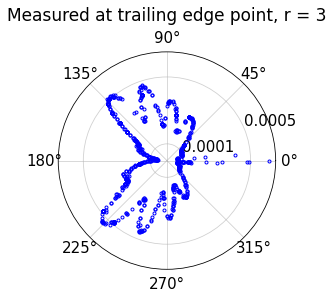

In [29]:
#a
#plt.polar(paper_dp8_theta/180*pi,paper_dp8_scale,'r.')
plt.polar(theta_plot1,dptuda_rms_plot,'b.')
plt.ylim([0,0.00065])
plt.yticks([0.0001, 0.0005])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
plt.grid(True)
#plt.legend(loc='best')
plt.title('Measured at trailing edge point, r = 3', va='bottom')